Epoch 0: Loss = 27.440849
Epoch 100: Loss = 0.336925
Epoch 200: Loss = 0.213451
Epoch 300: Loss = 0.136978
Epoch 400: Loss = 0.094045
Epoch 500: Loss = 0.066793
Epoch 600: Loss = 0.045267
Epoch 700: Loss = 0.028529
Epoch 800: Loss = 0.016468
Epoch 900: Loss = 0.009036
Epoch 1000: Loss = 0.005183
Epoch 1100: Loss = 0.003425
Epoch 1200: Loss = 0.002609
Epoch 1300: Loss = 0.002201
Epoch 1400: Loss = 0.001972
Epoch 1500: Loss = 0.001828
Epoch 1600: Loss = 0.001726
Epoch 1700: Loss = 0.001623
Epoch 1800: Loss = 0.001532
Epoch 1900: Loss = 0.001444


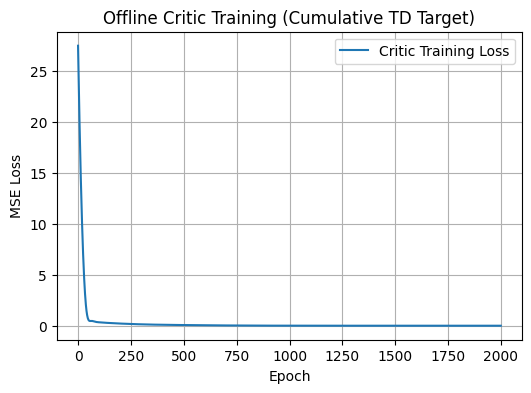

Max error on specified grid: 227.58


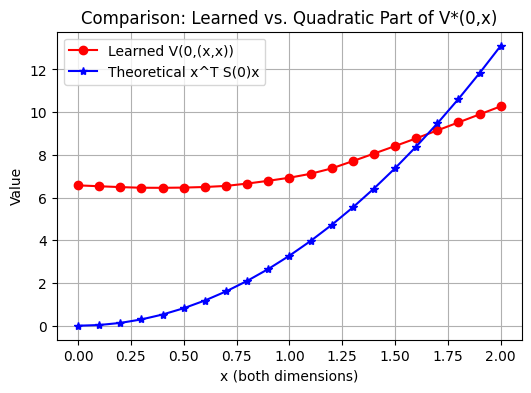

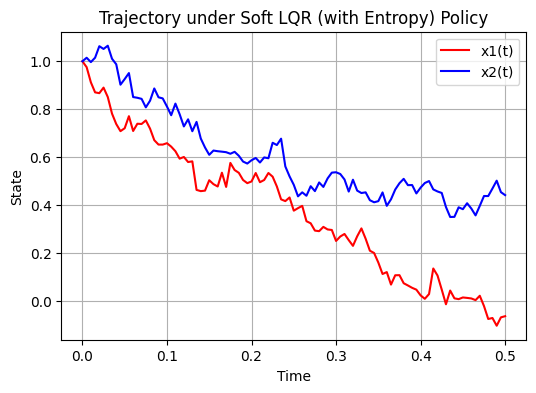

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from torch.distributions.multivariate_normal import MultivariateNormal

########################################
# 1. Riccati ODE 求解函数
########################################
def riccati_ode(t, S_flat, H, M, C, D_eff):
    """
    Riccati ODE 的右侧函数：
      dS/dt = S M D_eff^{-1} M^T S - H^T S - S H - C
    """
    dim = 2
    S = torch.tensor(S_flat, dtype=torch.float32).reshape(dim, dim)
    D_eff_inv = torch.linalg.inv(D_eff)
    Sdot = S @ M @ D_eff_inv @ M.T @ S - H.T @ S - S @ H - C
    return Sdot.flatten().numpy()

def solve_riccati(H, M, C, R, D_eff, T, N):
    """
    利用 solve_ivp 从 t=T 逆向到 t=0 求解 Riccati ODE，
    得到 S(t) 的数值解，存入字典（键为 t）。
    """
    t_grid = np.linspace(T, 0, N+1)
    S_T_flat = R.flatten().numpy()  # S(T)=R
    sol = solve_ivp(lambda t, y: riccati_ode(t, y, H, M, C, D_eff),
                    t_span=[T, 0], y0=S_T_flat, t_eval=t_grid,
                    atol=1e-10, rtol=1e-10)
    # 反转为正序时间
    S_solutions = sol.y.T[::-1]
    t_grid_forward = np.linspace(0, T, N+1)
    S_dict = {round(t, 10): S_solutions[i].reshape(2,2) for i, t in enumerate(t_grid_forward)}
    return S_dict

########################################
# 辅助函数：获取最接近的时间键
########################################
def get_nearest_time(S_dict, t_val):
    """
    在 S_dict 的键中找到离 t_val 最近的一个
    """
    times = list(S_dict.keys())
    nearest_t = min(times, key=lambda x: abs(x - t_val))
    return nearest_t

########################################
# 2. SoftLQR 类：带熵正则的最优松弛策略与 SDE 模拟
########################################
class SoftLQR:
    """
    SoftLQR：带熵正则的 LQR 问题
      状态方程： dX = H X dt + M a dt + sigma dW
      成本： ∫ (x^T C x + a^T D a + tau ln p(a|x)) dt + x_T^T R x_T
    控制策略： a ~ N(mean, cov)
      其中 mean = -D_eff^{-1} M^T S(t)x,  cov = tau * D_eff,
      D_eff = D + (tau/(2*gamma^2)) I.
    """
    def __init__(self, H, M, C, D, R, sigma, T, N, tau=0.5, gamma=1.0):
        self.H = H; self.M = M; self.C = C; self.D = D; self.R = R
        self.sigma = sigma; self.T = T; self.N = N
        self.tau = tau; self.gamma = gamma; self.dt = T / N
        # 计算 D_eff = D + (tau/(2*gamma^2)) I
        self.D_eff = self.D + (self.tau / (2 * (self.gamma ** 2))) * torch.eye(2)
        # 求解 Riccati ODE 得到 S(t)
        self.S_dict = solve_riccati(H, M, C, R, self.D_eff, T, N)

    def simulate_one_trajectory(self, x0, dW):
        """
        使用 Euler–Maruyama 模拟一条轨迹，
        返回 [(t, x, cost, x_next), ..., (t_T, x_T, None, None)]
        其中 cost = x^T C x + a^T D a + tau ln p(a|x) （未乘 dt，TD中乘 dt）
        """
        data = []
        x_n = x0.clone()
        t_n = 0.0
        for n in range(self.N):
            # 获取当前时刻 S(t)
            S_t = torch.tensor(self.S_dict[round(t_n, 10)], dtype=torch.float32)
            # 计算控制均值： -D_eff^{-1} M^T S(t) x_n
            mean = - torch.linalg.inv(self.D_eff) @ self.M.T @ S_t @ x_n
            # 控制协方差： tau * D_eff
            cov = self.tau * self.D_eff
            dist = MultivariateNormal(mean, cov)
            a_n = dist.sample()
            # 计算熵正则项： tau * ln p(a|x)
            ln_prob = dist.log_prob(a_n).item()
            # 即时成本： 状态成本 + 控制成本 + 熵正则项（未乘 dt）
            cost_n = (x_n.T @ self.C @ x_n + a_n.T @ self.D @ a_n).item() + self.tau * ln_prob
            # Euler–Maruyama 更新状态
            drift = self.H @ x_n + self.M @ a_n
            x_next = x_n + self.dt * drift + self.sigma @ dW[n]
            data.append((t_n, x_n.clone(), cost_n, x_next.clone()))
            x_n = x_next
            t_n += self.dt
        data.append((t_n, x_n.clone(), None, None))
        return data

########################################
# 3. OfflineCritic 类：严格按照算法定义的累计成本损失函数
########################################
class OfflineCritic:
    """
    OfflineCritic 利用固定策略采样的数据训练价值网络 Vθ(t,x)。
    算法目标：对于每个时刻 n，
      target_n = (∑_{k=n}^{N-1} [f_k + τ ln p(a_k|x_k)]·dt) + (x_T^T R x_T),
    损失函数： L(η) = ∑_{n=0}^{N-1} (Vθ(t_n,x_n) - target_n)^2.
    """
    def __init__(self, R, hidden_size=512, lr=1e-3):
        self.R = R
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),  # 输入维度为 3：[t, x1, x2]
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.mse_loss = nn.MSELoss()
        
    def train_cumulative(self, data, dt, epochs=1000):
        """
        离线训练价值网络：对每个时刻 n，计算累计成本 target_n，
        target_n = (∑_{k=n}^{N-1} (cost_k · dt)) + (x_T^T R x_T).
        损失： L(η) = ∑_{n=0}^{N-1} (Vθ(t_n,x_n) - target_n)^2.
        """
        # 将 data 分为非终端轨迹和终端样本
        traj = data[:-1]
        term = data[-1]
        x_T = term[1]
        terminal_cost = (x_T.T @ self.R @ x_T).item()
        
        # 计算每个时刻的累计成本
        cumulative_costs = []
        L = len(traj)
        for n in range(L):
            cum = 0.0
            for k in range(n, L):
                cum += traj[k][2] * dt
            cum += terminal_cost
            cumulative_costs.append(cum)
        
        # 提取非终端样本的时间和状态
        ts = [sample[0] for sample in traj]
        xs = [sample[1] for sample in traj]
        ts_tensor = torch.tensor(ts, dtype=torch.float32).unsqueeze(1)
        xs_tensor = torch.stack(xs).float()
        targets = torch.tensor(cumulative_costs, dtype=torch.float32)
        
        loss_history = []
        for ep in range(epochs):
            self.optimizer.zero_grad()
            inp = torch.cat([ts_tensor, xs_tensor], dim=1)  # 输入 [t, x]
            V_pred = self.net(inp).squeeze()
            loss = self.mse_loss(V_pred, targets)
            loss.backward()
            self.optimizer.step()
            loss_history.append(loss.item())
            if ep % 100 == 0:
                print(f"Epoch {ep}: Loss = {loss.item():.6f}")
        return loss_history

    def value_function(self, t, x):
        inp = torch.cat([torch.tensor([t], dtype=torch.float32), x.float()])
        return self.net(inp).item()

########################################
# 4. 主程序与验证
########################################
if __name__ == "__main__":
    # 参数设置
    H = torch.tensor([[0.5, 0.5],
                      [0.0, 0.5]], dtype=torch.float32)
    M = torch.tensor([[1.0, 1.0],
                      [0.0, 1.0]], dtype=torch.float32)
    C = torch.tensor([[1.0, 0.1],
                      [0.1, 1.0]], dtype=torch.float32)
    D = torch.eye(2, dtype=torch.float32)
    R = torch.tensor([[10.0, 3.0],
                      [3.0, 10.0]], dtype=torch.float32)
    sigma = 0.5 * torch.eye(2, dtype=torch.float32)
    T = 0.5
    N = 100
    tau = 0.5
    gamma = 1.0
    dt = T / N

    # 实例化 SoftLQR
    soft_lqr = SoftLQR(H, M, C, D, R, sigma, T, N, tau, gamma)
    # 生成布朗增量
    dW = torch.normal(mean=0.0, std=1.0, size=(N, 2)) * np.sqrt(dt)
    x0 = torch.tensor([1.0, 1.0])
    # 模拟轨迹，返回 (t, x, cost, x_next) 的列表
    data = soft_lqr.simulate_one_trajectory(x0, dW)
    
    # 离线 Critic 训练（累计目标版本）
    critic = OfflineCritic(R, hidden_size=512, lr=1e-3)
    loss_history = critic.train_cumulative(data, dt, epochs=2000)
    
    # 绘制训练损失曲线
    plt.figure(figsize=(6,4))
    plt.plot(loss_history, label='Critic Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Offline Critic Training (Cumulative TD Target)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 在指定的时间点 t in {0, 1/6, 2/6, 0.5} 与网格上比较离线 Critic 学到的 V(t,x) 与理论值 x^T S(t)x
    t_check = [0.0, 1/6, 2/6, 0.5]
    grid = np.linspace(-3, 3, 13)
    max_error = 0.0
    for t_val in t_check:
        # 使用辅助函数找出最接近 t_val 的时间键
        t_key = get_nearest_time(soft_lqr.S_dict, t_val)
        S_t = torch.tensor(soft_lqr.S_dict[t_key], dtype=torch.float32)
        for xv in grid:
            for yv in grid:
                x_vec = torch.tensor([xv, yv], dtype=torch.float32)
                V_learned = critic.value_function(t_val, x_vec)
                V_theoretical = (x_vec.T @ S_t @ x_vec).item()
                err = abs(V_learned - V_theoretical)
                if err > max_error:
                    max_error = err
    print(f"Max error on specified grid: {max_error:.2f}")
    
    # 对比 t=0 时学到的价值函数与理论二次项 x^T S(0)x 的曲线
    S0 = torch.tensor(soft_lqr.S_dict[0.0], dtype=torch.float32)
    xs_plot = np.linspace(0, 2, 21)
    learned_vals = []
    theoretical_vals = []
    for xv in xs_plot:
        x_val = torch.tensor([xv, xv], dtype=torch.float32)
        V_learned = critic.value_function(0.0, x_val)
        learned_vals.append(V_learned)
        V_theoretical = (x_val.T @ S0 @ x_val).item()
        theoretical_vals.append(V_theoretical)
    
    plt.figure(figsize=(6,4))
    plt.plot(xs_plot, learned_vals, 'ro-', label='Learned V(0,(x,x))')
    plt.plot(xs_plot, theoretical_vals, 'b*-', label='Theoretical x^T S(0)x')
    plt.xlabel('x (both dimensions)')
    plt.ylabel('Value')
    plt.title('Comparison: Learned vs. Quadratic Part of V*(0,x)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 绘制轨迹演化图：展示系统状态随时间的变化
    dW2 = torch.normal(mean=0.0, std=1.0, size=(N, 2)) * np.sqrt(dt)
    data_check = soft_lqr.simulate_one_trajectory(x0, dW2)
    ts = [d[0] for d in data_check]
    x1_vals = [d[1][0].item() for d in data_check]
    x2_vals = [d[1][1].item() for d in data_check]
    plt.figure(figsize=(6,4))
    plt.plot(ts, x1_vals, 'r-', label='x1(t)')
    plt.plot(ts, x2_vals, 'b-', label='x2(t)')
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title('Trajectory under Soft LQR (with Entropy) Policy')
    plt.legend()
    plt.grid(True)
    plt.show()
